<a href="https://colab.research.google.com/github/kostarakonjac1331/AE-C-network/blob/main/AE%26C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTOVI


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,LeakyReLU,BatchNormalization,Dropout,Input,MaxPool2D,Flatten,Activation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools



In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

KONVOLUCIONI AUTOENCODER


In [ ]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    #encoder mreza
    self.encoder = keras.Sequential([
      Input(shape=(28,28,1)),
      Conv2D(64,kernel_size=3,strides=2,padding='same',activation='relu'),
      Conv2D(32,kernel_size=3,strides=2,padding='same',activation='relu')
    ])

    #decoder mreza
    self.decoder = keras.Sequential([
      Conv2DTranspose(32,kernel_size=3,strides=2,padding='same',activation='relu'),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same',activation='relu'),
      Conv2D(1,kernel_size=3,padding='same',activation='relu')
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




KONVOLUCIONI KLASIFIKATOR

In [ ]:
class CNNClasificator(Model):
  def __init__(self):
    super(CNNClasificator,self).__init__()
    self.cnn = keras.Sequential([
      Conv2D(16,3,padding='same',input_shape=(28,28,1)),
      LeakyReLU(0.2),
      Conv2D(16,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.2),
      MaxPool2D(),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(32,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.3),
      MaxPool2D(),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Conv2D(64,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.3),
      MaxPool2D(),
      Conv2D(128,3,padding='same'),
      LeakyReLU(0.2),
      Dropout(0.4),
      MaxPool2D(),
      Flatten(),
      Dense(512),
      LeakyReLU(0.2),
      BatchNormalization(),
      Dense(64),
      LeakyReLU(0.2),
      BatchNormalization(),
      Dropout(0.4),
      Dense(10)
      ])
  def call(self,x):
    x = self.cnn(x)
    return x


model = CNNClasificator()

In [ ]:
class AEC:
  def __init__(self,train_data,test_data,train_labels,test_labels,noisy_train,noisy_test):
    self.train_data = train_data
    self.test_data = test_data
    self.train_labels = train_labels
    self.test_labels = test_labels
    self.noisy_test = noisy_test
    self.noisy_train = noisy_train
    self.autoencoder = AutoEncoder()
    self.clasificator = CNNClasificator()
    self.history = None
    self.predictions = None
  

  def trainAutoEncoder(self):
    self.autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())

    self.autoencoder.fit(self.noisy_train, self.train_data,
                epochs=10,
                shuffle=True,
                validation_data=(self.noisy_test, self.test_data))
    print(self.autoencoder.encoder.summary())
    print(self.autoencoder.decoder.summary())

    print("rezultat treniranja: \n")
    encoded_imgs = model.autoencoder.encoder(x_test).numpy()
    decoded_imgs = model.autoencoder.decoder(encoded_imgs).numpy()
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      plt.imshow(tf.squeeze(x_test_noisy[i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      bx = plt.subplot(2, n, i + n + 1)
      plt.title("rekonstruisana")
      plt.imshow(tf.squeeze(decoded_imgs[i]))
      plt.gray()
      bx.get_xaxis().set_visible(False)
      bx.get_yaxis().set_visible(False)
    plt.show()


  def trainClasificator(self):
    self.clasificator.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
    )
    self.history = self.clasificator.fit(self.train_data, self.train_labels, batch_size=64, epochs=10, verbose=2,validation_data=(self.test_data,self.test_labels))
    self.predictions = np.argmax(self.clasificator.predict(x=self.test_data, batch_size=64, verbose=0),axis=1)

  def clasifierPredict(self,picture):
    picture = tf.expand_dims(input=picture,axis=0)
    predikcija = self.clasificator.predict(x=picture,batch_size=64)
    roundPredikcija = np.argmax(predikcija)
    return roundPredikcija

  def plotAccuracy(self):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
  
  def plotLoss(self):
    plt.plot(self.history.history['loss'], label='loss')
    plt.plot(self.history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.clasificator.evaluate(self.test_data, self.test_labels, verbose=2)


  def plot_confusion_matrix(self,target_names,title='Matrica konfuzije',cmap=None,normalize=True):
    cm = confusion_matrix(y_true=self.test_labels, y_pred=self.predictions)
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
      cmap = plt.get_cmap('magma')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thtest_labelsresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")


    plt.tight_layout()
    plt.ylabel('Tacne klase')
    plt.xlabel('Prediktovane klase\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


  def encodingDecoding(self,picture):
    picture = tf.expand_dims(input = picture, axis = 0)
    enc = self.autoencoder.encoder(picture)
    dec = self.autoencoder.decoder(enc)

    return dec

    

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 0.0106 - val_loss: 0.0029
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.00

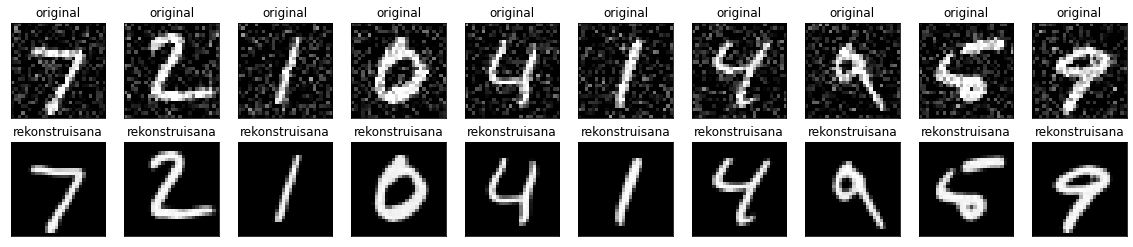

In [ ]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy)
model.trainAutoEncoder()


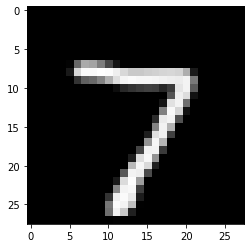

In [ ]:
dc = model.encodingDecoding(x_test[0])
plt.imshow(tf.squeeze(dc))


In [ ]:
model.trainClasificator()

Epoch 1/10
938/938 - 7s - loss: 0.4520 - accuracy: 0.8597 - val_loss: 0.5500 - val_accuracy: 0.8186
Epoch 2/10
938/938 - 6s - loss: 0.1053 - accuracy: 0.9703 - val_loss: 0.1837 - val_accuracy: 0.9553
Epoch 3/10
938/938 - 6s - loss: 0.0733 - accuracy: 0.9798 - val_loss: 0.0552 - val_accuracy: 0.9872
Epoch 4/10
938/938 - 6s - loss: 0.0614 - accuracy: 0.9826 - val_loss: 0.0863 - val_accuracy: 0.9788
Epoch 5/10
938/938 - 6s - loss: 0.0510 - accuracy: 0.9852 - val_loss: 0.0402 - val_accuracy: 0.9885
Epoch 6/10
938/938 - 6s - loss: 0.0457 - accuracy: 0.9866 - val_loss: 0.0681 - val_accuracy: 0.9817
Epoch 7/10
938/938 - 6s - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0478 - val_accuracy: 0.9884
Epoch 8/10
938/938 - 6s - loss: 0.0392 - accuracy: 0.9891 - val_loss: 0.0483 - val_accuracy: 0.9873
Epoch 9/10
938/938 - 6s - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 10/10
938/938 - 6s - loss: 0.0319 - accuracy: 0.9906 - val_loss: 0.0330 - val_accuracy: 0.9906

In [ ]:
dc.shape
a = tf.squeeze(dc)
a = tf.expand_dims(input=a,axis = 2)

pred = model.clasifierPredict(a)
pred

7

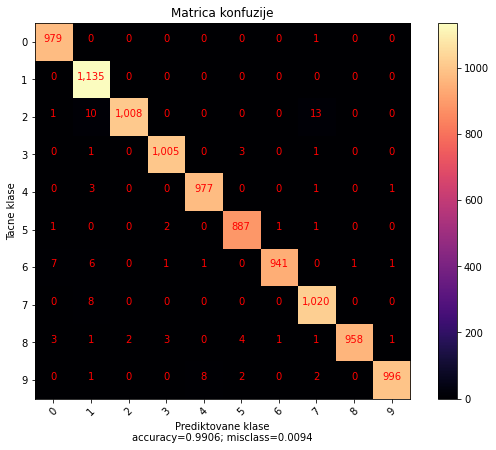

In [ ]:
model.plot_confusion_matrix(target_names=['0','1','2','3','4','5','6','7','8','9',], title="Matrica konfuzije", normalize=False)

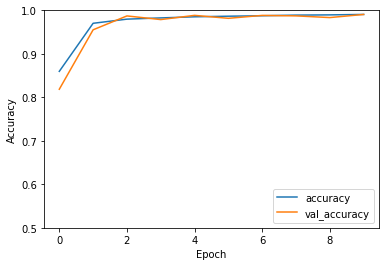

In [ ]:
model.plotAccuracy()

313/313 - 1s - loss: 0.0330 - accuracy: 0.9906


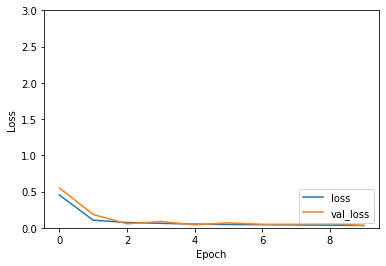

In [ ]:
model.plotLoss()